# Create the input data to test the shapes algorithm

In [1]:
# import standard packages
import os, numpy, pandas, scipy
from scipy import ndimage
from functions_shapes import *
import matplotlib as mpl

# import the function to calculate the Modified Hausdorff Distance
from class_hausdorff import ModHausdorffDist


In [2]:
# define plotting properties
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['font.size'] = 24.0
mpl.rcParams['legend.fontsize'] = 21.0
mpl.rcParams['legend.numpoints'] = 1
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['lines.marker'] = "4"

### General variables

In [3]:
# directory that contains the input data
path = os.path.join(os.getcwd(), "input_data")

# highest surface brightness - magnitudes/arcsec^2
cut_surfbright = 28

# define the outer radius of the data - units: kpc
rgclim = 780
# define the width of the images - units: kpc
width = 2*rgclim
# define the number of pixels
number_of_pixels = 1024
# define the width per pixel - units: kpc
width_per_pixel = width / (number_of_pixels)

# size of the gaussian kernel to smooth images with
factor_sigma = 0.02 # units: in units of rgclim


## Option 1: use an image (e.g. a stellar surface brightness image) & apply a cut

In [4]:
# load the original image
fname = "dummy_stars_surfbrightim_original.npz"
with numpy.load(os.path.join(path, fname)) as npz:
    im_ma = numpy.ma.MaskedArray(**npz)

# mask the image by a certain surface brightness value
mask = im_ma.data > cut_surfbright
# fill in the masked values 
im_ma.data[mask] = cut_surfbright + 2
im_ma.mask = mask

# save the masked image
fname = "dummy_stars_surfbrightim_cut{:d}.npz".format(cut_surfbright)
numpy.savez_compressed(os.path.join(path, fname), data=im_ma.data, mask=im_ma.mask)


## Option 2: generate an image (e.g. from a GC catalogue)

### create a dummy GC catalogue using Pandas

In [5]:
### create a dummy GC catalogue using Pandas
fname = "fof000_volume_gcs_arrays_brightness_cuts_peakGCMF_f336w475w814w.npz"
gcs_arrays = numpy.load(os.path.join(path, fname))
        
# prepare column names
column_names = ["x [kpc]", "y [kpc]", "MF814W"]

# papre the dictionary with the data 
sample_dict = {"x" : gcs_arrays["mask_gcs_pos"][:,0],
              "y" : gcs_arrays["mask_gcs_pos"][:,1],
              "MF814W" : gcs_arrays["mask_gcs_mags_814W"]}
# convert into a dataframe
df = pandas.DataFrame.from_dict(sample_dict) 
# save as a csv file
df.to_csv(os.path.join(path, "dummy_gcs_catalogue.csv"),
            sep = "\t", float_format = "%.5f", index = False,  header=column_names)

### Create the GC number density image

In [6]:
# load the dummy catalogue
fname = os.path.join(path, "dummy_gcs_catalogue.csv")
gcs_catalogue = pandas.read_csv(fname, sep = "\t")

### generate the image
# define the bins
bins = numpy.linspace(-width/2, width/2., number_of_pixels+1)
# create the number density image of GCs - units: kpc^-2
im = create_gcs_image(gcs_catalogue["x [kpc]"],
                      gcs_catalogue["y [kpc]"], bins, 
                      weights = numpy.ones(shape=len(gcs_catalogue["x [kpc]"])))

# save the image
fname = os.path.join(path, "dummy_gcs_numdenim")
numpy.savez(fname, im = im)


# Smooth the images with a gaussian kernel

In [7]:
# load the stellar surface brightness map
fname = os.path.join(path,"dummy_stars_surfbrightim_cut{:d}.npz".format(cut_surfbright))
with numpy.load(fname) as npz:
    im_ma = numpy.ma.MaskedArray(**npz) 
# extract the image
im_stars_surfbright = im_ma.filled(cut_surfbright+2)

# load the GC number density image
fname = os.path.join(path, "dummy_gcs_numdenim.npz")
im_gcs_number = numpy.load(fname)["im"]

### smooth the images with a gaussian kernel
sigma_px  = factor_sigma*rgclim/width_per_pixel # kernel size in pixels

# stellar surface brightness maps
smooth_img_stars = scipy.ndimage.gaussian_filter(im_stars_surfbright, sigma_px)
fname = os.path.join(path,
        "dummy_stars_surfbrightim_cut{:d}_smoothim_sigma{:.3f}rgclim".format(cut_surfbright,
                                                                             factor_sigma).replace(".", "p"))
numpy.savez(fname, im = smooth_img_stars)

# GC number density
smooth_img_gcs = scipy.ndimage.gaussian_filter(im_gcs_number, sigma_px)
fname = os.path.join(path,
        "dummy_gcs_numdenim_smoothim_sigma{:.3f}rgclim".format(factor_sigma).replace(".", "p"))
numpy.savez(fname, im = smooth_img_gcs)
                

# Identify isodensity contours

Saving figure as ./plot_contours_gcs_gmagcut_number.pdf


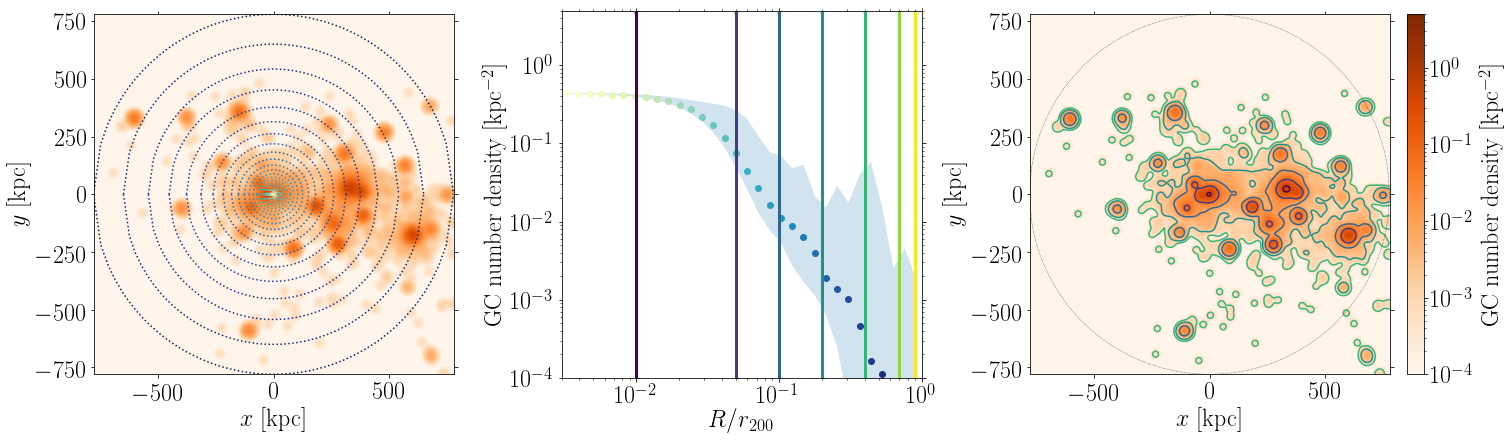

In [8]:
# define the radii at which contours should be drawn - in units of rgclim
rad_rrgclim_contours = numpy.asarray([0.01,0.05,0.1,0.2,0.4,0.7,0.9])

# identify the (longest) contours in the stellar surface brightness map
star_contours, star_rad_profile = identify_isodensity_contours(smooth_img_stars, rgclim, 
                                                               rad_rrgclim_contours, 
                                                               do_component = "star", 
                                                               do_img = True, 
                                                               return_contours = True,
                                                               return_rad_profile = True,
                                                               annotation = "", postfix = "",
                                                               cut_surfbright = cut_surfbright)
# identify the (longest) contours in the GC surface number density map
gcs_contours, gcs_rad_profile = identify_isodensity_contours(smooth_img_gcs, rgclim, 
                                                               rad_rrgclim_contours, 
                                                               do_component = "gcs", 
                                                               do_img = True, 
                                                               return_contours = True,
                                                               return_rad_profile = True,
                                                               annotation = "", postfix = "")


# Measure the Modified Hausdorff Distance between two pairs of contours

In [9]:

# look at MHD between pairs of stellar and GC isodensity contours in the levels in common
for level in numpy.intersect1d(list(star_contours.keys()), list(gcs_contours.keys())):
    # 0: inner radial contour level
    # units: kpc
    print(level, ModHausdorffDist(star_contours[level], gcs_contours[level])[0])


0 37.170054219618436
1 33.015679333919806
2 223.25974243323205
3 303.5191418894553
4 325.7127663360137
